---
title: "Snowflake Storage Cortex Forecast Example"
date: "08/25/2024"
format:
    html:
        code-fold: False
        output: False
---

# Overview

In [1]:
%load_ext autoreload
%autoreload 2

# Example Useage

In [2]:
#| skip
from snowflake.snowpark.version import VERSION
from cortex_forecast.forecast import SnowflakeMLForecast
import os

## Create Snowflake Connection Using SnowflakeMLForecast


> Note: Make sure that you create a yaml file that you would like to so that the SnowflakeMLForecast can read the connection information from it and be able to build your forecast.

In [3]:
#| skip
forecast_model = SnowflakeMLForecast(
    config_file='./cortex_forecast/files/yaml/storage_forecast_config.yaml',
    connection_config={
        'user': os.getenv('SNOWFLAKE_USER'),
        'password': os.getenv('SNOWFLAKE_PASSWORD'),
        'account': os.getenv('SNOWFLAKE_ACCOUNT'),
        'database': 'CORTEX',
        'warehouse': 'CORTEX_WH',
        'schema': 'DEV',
        'role': 'CORTEX_USER_ROLE'  # Use the desired role
    },
    is_streamlit=False
)

snowflake_environment = forecast_model.session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION
print('\nConnection Established with the following parameters:')
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0], snowpark_version[1], snowpark_version[2]))


Connection Established with the following parameters:
Snowflake version           : 8.33.1
Snowpark for Python version : 1.18.0


### Create a Training Table

In [4]:
#| skip
# Create Training Data
training_days = 365

forecast_model.session.sql(f'''CREATE OR REPLACE TABLE storage_usage_train AS
    SELECT 
        TO_TIMESTAMP_NTZ(usage_date) AS usage_date,
        storage_bytes / POWER(1024, 3) AS storage_gb
    FROM 
    (
        SELECT * 
            FROM snowflake.account_usage.storage_usage
            WHERE usage_date < CURRENT_DATE()
    )
    WHERE TO_TIMESTAMP_NTZ(usage_date) > DATEADD(day, -{training_days}, CURRENT_DATE())
''').collect()
forecast_model.session.sql('SELECT * FROM storage_usage_train ORDER BY usage_date DESC LIMIT 10').show()

--------------------------------------------
|"USAGE_DATE"         |"STORAGE_GB"        |
--------------------------------------------
|2024-09-05 00:00:00  |280.0245177047327   |
|2024-09-04 00:00:00  |273.75833379570395  |
|2024-09-03 00:00:00  |267.7940624393523   |
|2024-09-02 00:00:00  |265.5218228260055   |
|2024-09-01 00:00:00  |265.05640272889286  |
|2024-08-31 00:00:00  |265.0566206406802   |
|2024-08-30 00:00:00  |265.0504933735356   |
|2024-08-29 00:00:00  |265.32130791060627  |
|2024-08-28 00:00:00  |265.77701564040035  |
|2024-08-27 00:00:00  |267.33904562331736  |
--------------------------------------------



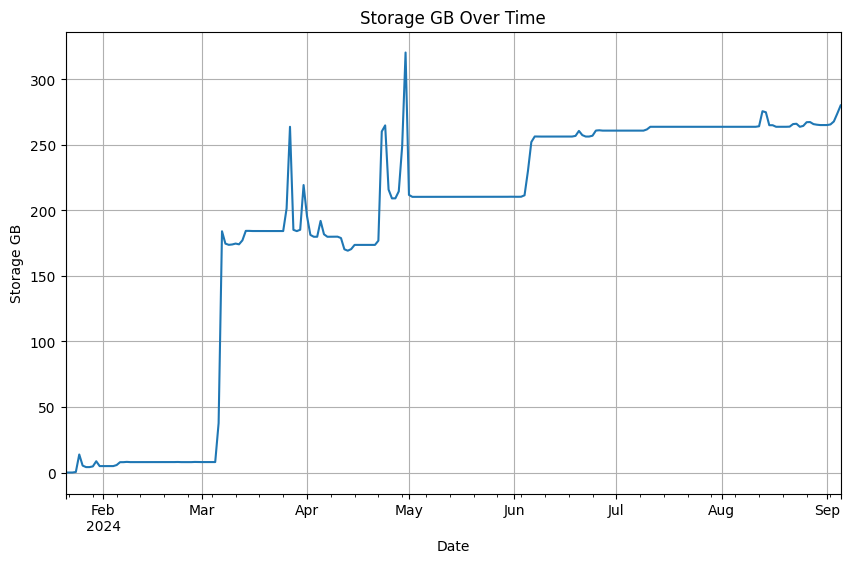

In [5]:
#| skip
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = forecast_model.session.sql('SELECT * FROM storage_usage_train ORDER BY usage_date').to_pandas()
df.head()
df = df.set_index('USAGE_DATE')
df['STORAGE_GB'].plot(figsize=(10, 6), title='Storage GB Over Time')

# Show the plot
plt.xlabel('Date')
plt.ylabel('Storage GB')
plt.grid(True)
plt.show()


### Train a Model

> This will use what is inside of the yaml file that you created that you passed over to the SnowflakeMLForecast object


In [6]:
#| skip
# Run Forecast
forecast_data = forecast_model.create_and_run_forecast()
forecast_data.head()

Attempting to create tag: environment
Tag 'environment' already exists.
Attempting to create tag: team
Tag 'team' already exists.
Step 1/4: Creating training table...
Generated SQL:

        CREATE OR REPLACE TEMPORARY TABLE my_forecast_model_20240906_nnxbw_train AS
        SELECT TO_TIMESTAMP_NTZ(usage_date) AS usage_date, storage_gb AS storage_gb, * EXCLUDE (usage_date, storage_gb)
        FROM storage_usage_train
        
            WHERE TO_TIMESTAMP_NTZ(usage_date) 
            BETWEEN 
            DATEADD(day, -365, (SELECT MAX(usage_date) FROM storage_usage_train)) 
            AND 
            (SELECT MAX(usage_date) FROM storage_usage_train)
            ;
Step 2/4: Creating forecast model...
Generated SQL:

        CREATE OR REPLACE SNOWFLAKE.ML.FORECAST my_forecast_model_20240906_nnxbw(
            INPUT_DATA => SYSTEM$REFERENCE('table', 'my_forecast_model_20240906_nnxbw_train'),
            TIMESTAMP_COLNAME => 'usage_date',
            TARGET_COLNAME => 'storage_gb',
     

,USAGE_DATE,FORECAST,LOWER_BOUND,UPPER_BOUND,MODEL_NAME,CREATION_DATE,MODEL_COMMENT
0,2024-09-06,280.135098,277.505511,282.764686,my_forecast_model_20240906_nnxbw,2024-09-06 15:27:40.700000-07:00,Forecast model for predicting sales trends.
1,2024-09-07,278.517528,274.798729,282.236327,my_forecast_model_20240906_nnxbw,2024-09-06 15:27:40.700000-07:00,Forecast model for predicting sales trends.
2,2024-09-08,278.501115,273.946536,283.055695,my_forecast_model_20240906_nnxbw,2024-09-06 15:27:40.700000-07:00,Forecast model for predicting sales trends.
3,2024-09-09,279.003164,273.743989,284.262340,my_forecast_model_20240906_nnxbw,2024-09-06 15:27:40.700000-07:00,Forecast model for predicting sales trends.
4,2024-09-10,278.245462,272.365525,284.125399,my_forecast_model_20240906_nnxbw,2024-09-06 15:27:40.700000-07:00,Forecast model for predicting sales trends.


In [7]:
forecast_model.generate_forecast_and_visualization(show_historical=True)

Executing forecast query:

            SELECT *
            FROM storage_forecast_results
            WHERE model_name = 'my_forecast_model_20240906_nnxbw'
            ORDER BY usage_date DESC
        
Forecast data preview (last 5 rows):


,USAGE_DATE,FORECAST,LOWER_BOUND,UPPER_BOUND,MODEL_NAME,CREATION_DATE,MODEL_COMMENT
25,2024-09-10,278.245462,272.365525,284.125399,my_forecast_model_20240906_nnxbw,2024-09-06 15:27:40.700000-07:00,Forecast model for predicting sales trends.
26,2024-09-09,279.003164,273.743989,284.262340,my_forecast_model_20240906_nnxbw,2024-09-06 15:27:40.700000-07:00,Forecast model for predicting sales trends.
27,2024-09-08,278.501115,273.946536,283.055695,my_forecast_model_20240906_nnxbw,2024-09-06 15:27:40.700000-07:00,Forecast model for predicting sales trends.
28,2024-09-07,278.517528,274.798729,282.236327,my_forecast_model_20240906_nnxbw,2024-09-06 15:27:40.700000-07:00,Forecast model for predicting sales trends.
29,2024-09-06,280.135098,277.505511,282.764686,my_forecast_model_20240906_nnxbw,2024-09-06 15:27:40.700000-07:00,Forecast model for predicting sales trends.


Executing historic actuals query:

            SELECT usage_date, storage_gb
            FROM storage_usage_train
            ORDER BY usage_date DESC
            LIMIT 21
            
Historical data preview (last 5 rows):


,USAGE_DATE,STORAGE_GB
16,2024-08-20,263.743386
17,2024-08-19,263.740114
18,2024-08-18,263.736670
19,2024-08-17,263.737937
20,2024-08-16,264.926883


Getting historical max date
Max historical date: 2024-09-05 00:00:00
Combined data preview (last 5 rows):


,USAGE_DATE,TYPE,VALUE_TYPE,VOLUME
127,2024-09-10,Forecast,UPPER_BOUND,284.125399
128,2024-09-09,Forecast,UPPER_BOUND,284.262340
129,2024-09-08,Forecast,UPPER_BOUND,283.055695
130,2024-09-07,Forecast,UPPER_BOUND,282.236327
131,2024-09-06,Forecast,UPPER_BOUND,282.764686


alt.LayerChart(...)

Top 10 Feature Importances


alt.Chart(...)

,SERIES,RANK,FEATURE_NAME,SCORE,FEATURE_TYPE
0,None,1,lag7,0.09,derived_from_endogenous
2,None,3,lag28,0.08,derived_from_endogenous
1,None,2,lag14,0.08,derived_from_endogenous
3,None,4,aggregated_endogenous_trend_features,0.07,derived_from_endogenous
4,None,5,lag56,0.07,derived_from_endogenous
5,None,6,lag21,0.06,derived_from_endogenous
6,None,7,lag35,0.06,derived_from_endogenous
7,None,8,lag63,0.06,derived_from_endogenous
10,None,11,lag42,0.05,derived_from_endogenous
12,None,13,lag77,0.05,derived_from_endogenous


Underlying Model Metrics


,SERIES,ERROR_METRIC,METRIC_VALUE,STANDARD_DEVIATION,LOGS
0,None,MAE,5.445,1.344,None
1,None,MAPE,0.020,0.005,None
2,None,MSE,49.842,4.165,None
3,None,SMAPE,0.020,0.005,None
4,None,COVERAGE_INTERVAL=0.95,0.977,0.032,None
5,None,WINKLER_ALPHA=0.05,55.907,37.697,None
6,None,MDA,0.667,0.067,None
